# Testing the Simplified Betts-Miller convection scheme

The scheme is described by [Frierson (2007), J. Atmos. Sci. 64, doi:10.1175/JAS3935.1](https://doi.org/10.1175/JAS3935.1).

This is a work in progress to wrap the Fortran code from Dargan Frierson into a climlab process.

## Building from source

For now, this what you have to do to install and use the code. First, get yourself a copy of the [source repo on github](https://github.com/brian-rose/climlab-sbm-convection). Then do the following.

### Build environment

Here are instructions to create a build environment (including Fortran compiler) with conda/mamba

Starting from the root of the `climlab-sbm-convection` repo *(example for Apple M1 machine, see `./ci/` for other environment files)*:
```
mamba create --name sbm_build_env python=3.10 --channel conda-forge
mamba env update --file ./ci/requirements-macos-arm64.yml
conda activate sbm_build_env
```

### Building with f2py

From the root of the repository, do this:
```
f2py -c -m _simplified_betts_miller climlab_betts_miller.f90
```

This will create the shared object `_simplified_betts_miller.cpython-*.so` that can be imported in a Python session.

_This is a work in progress, and eventually there will be better packaging so this manual build step will not be needed._

## Some trivial tests

- Can we import the complied object? 
- Does it calculate saturation vapor pressure correctly?

In [1]:
# Do these three methods for calculating saturation vapor pressure agree?

import _simplified_betts_miller
from climlab.utils.thermo import clausius_clapeyron
import metpy.calc as mpcalc
from metpy.units import units

temperature = 280.  # in Kelvin
print(clausius_clapeyron(temperature))  # result in hPa
print(mpcalc.saturation_vapor_pressure(temperature * units.kelvin).to('hPa'))
print(_simplified_betts_miller.escomp(temperature)/100.)  # convert to hPa

9.911891305211338
9.91189130521134 hectopascal
9.911895751953125


/Users/br546577/miniconda3/envs/climlab-courseware/lib/python3.10/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


The three values agree to a high precision.

## A single column sounding

Here I'm using some sample data from the metpy package.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT


In [3]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('may22_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [4]:
# We will pull the data out of the example dataset into individual variables and
# assign units.

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

In [5]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

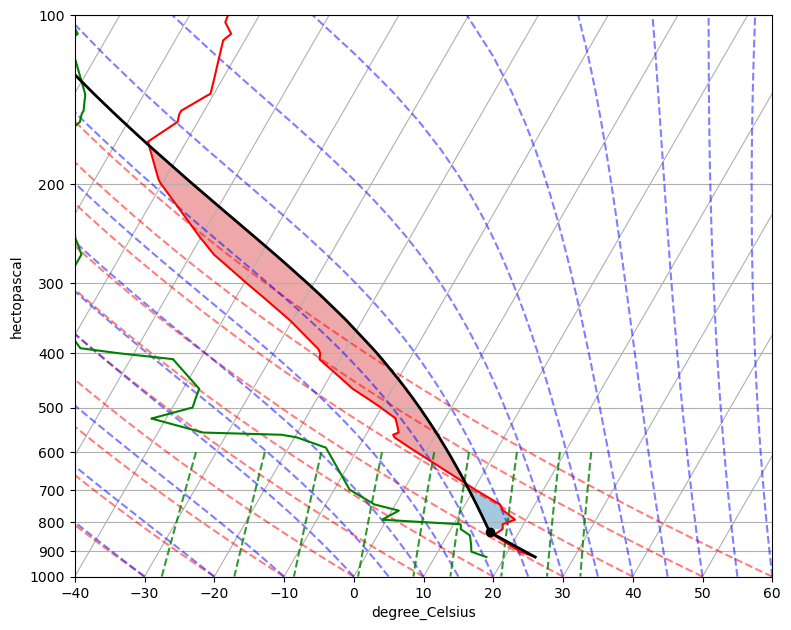

In [6]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

In [7]:
cape_metpy, cin_metpy = mpcalc.cape_cin(p, T, Td, parcel_prof)
print("CAPE from metpy is {}".format(cape_metpy))
print("CIN from metpy is {}".format(cin_metpy))

CAPE from metpy is 2598.547323198085 joule / kilogram
CIN from metpy is -55.01035661477351 joule / kilogram


### Do we get the same CAPE and CIN values as metpy?

I will make a manual call to the `capecalcnew` subroutine in the compiled Fortran object.

In [8]:
from climlab.utils import constants as const

Cp_air = const.cp 
rdgas = const.Rd 
rvgas = const.Rv
HLv = const.Lhvap 
kappa = const.kappa 
es0 = 1.0
avgbl = False  # If true, the parcel is averaged in theta and r up to its LCL -- not actually implemented
Grav = const.g

# model levels are the pressure levels in the dataset
pfull = p.to(units.pascals).magnitude  # convert units and strip units away
pfull = np.flip(pfull)  # convection code expects that first element of array is TOA

# assume that the interfaces are halfway between pressure levels
num_lev = pfull.size
phalf = np.zeros(num_lev+1)
phalf[1:-1] = pfull[:-1] + np.diff(pfull)/2
phalf[-1] = 100000.

tin = np.flip(T.to(units.kelvin).magnitude)
qin = np.flip(mpcalc.specific_humidity_from_dewpoint(p, Td).magnitude)
rin = np.flip(mpcalc.mixing_ratio_from_specific_humidity(mpcalc.specific_humidity_from_dewpoint(p, Td)).magnitude)

#  Call the calccalc routine
# !    Output:
# !    cape        Convective available potential energy
# !    cin         Convective inhibition (if there's no LFC, then this is set 
# !                to zero)
# !    tp          Parcel temperature (set to the environmental temperature 
# !                where no adjustment)
# !    rp          Parcel specific humidity (set to the environmental humidity 
# !                where no adjustment, and set to the saturation humidity at 
# !                the parcel temperature below the LCL)
# !    klzb        Level of zero buoyancy
cape_sbm, cin_sbm, tp,rp,klzb = _simplified_betts_miller.capecalcnew(num_lev,pfull,phalf,
                        Cp_air,rdgas,rvgas,HLv,kappa,es0,tin,rin,avgbl)

cape_sbm, cin_sbm

(2605.31640625, 122.73005676269531)

These values are fairly close to what metpy produced for the same sounding. I think the sign convention for CIN is opposite.

We can visualize the discrepancy by adding the SBM-produced parcel profile to the skew-T plot:

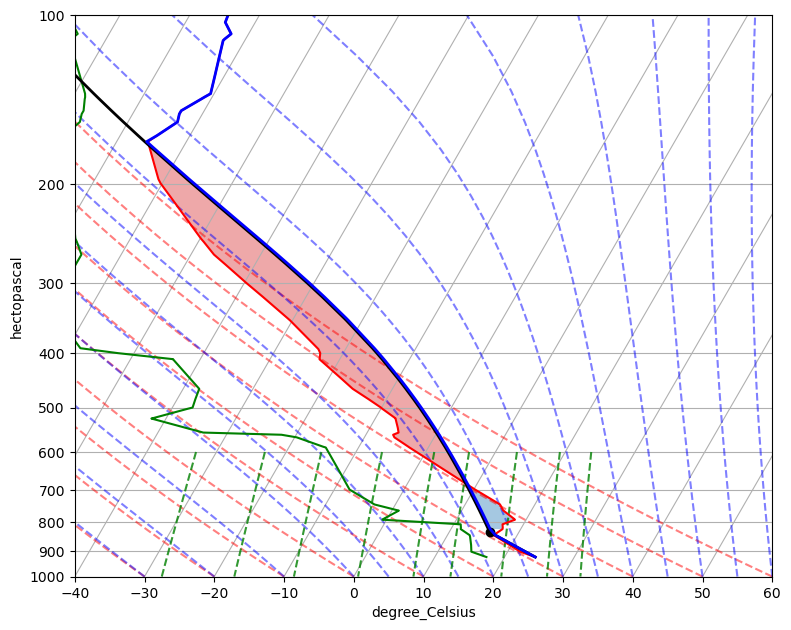

In [9]:
# add the SBM parcel profile to the existing plot
sbm_parcel_prof = np.flip(tp) * units.kelvin
skew.plot(p, sbm_parcel_prof, 'b', linewidth=2)
fig

Apparently in this case SBM has produced a parcel profile that is slightly cooler (slighly higher LCL) than metply. The integrals for CAPE and CIN are very sensitive to these details.

Metpy implements a more expensive iterative procedure for finding the LCL compared to SBM, which uses a simple lookup table.

## Calling the `betts_miller` subroutine

Let's now pass the same sounding to the `betts_miller` Fortran subroutine, so we can compute tendencies and diagnostics from the convection scheme.

In [10]:
dt = const.seconds_per_hour * 3
tau_bm=7200.
rhbm=0.7
do_simp=False
do_shallower=True
do_changeqref=True
do_envsat=True
do_taucape=False
capetaubm=900.
tau_min=2400.
ix = 1; jx = 1; kx = num_lev

tin_grid = tin[np.newaxis, np.newaxis, :]
qin_grid = qin[np.newaxis, np.newaxis, :]
rin_grid = rin[np.newaxis, np.newaxis, :]
pfull_grid = pfull[np.newaxis, np.newaxis, :]
phalf_grid = phalf[np.newaxis, np.newaxis, :]

rain, tdel, qdel, q_ref, bmflag, klzbs, cape, cin, t_ref, invtau_bm_t, invtau_bm_q, capeflag = \
    _simplified_betts_miller.betts_miller(dt, tin_grid, qin_grid, pfull_grid, phalf_grid, 
                                          HLv, Cp_air, Grav,
                                          rdgas,rvgas,kappa, es0, tau_bm, rhbm, 
                                          do_simp, do_shallower, do_changeqref, 
                                          do_envsat, do_taucape, capetaubm, tau_min, 
                                          ix, jx, kx,)

In [11]:
cape, cin, rain, bmflag, capeflag

(array([[2605.3164]], dtype=float32),
 array([[122.73006]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32))

This is consistent with the call to `capecalcnew` above. We get the same CAPE and CIN. No rain is produced because there is CIN in this sounding. Need to lift the parcel up!

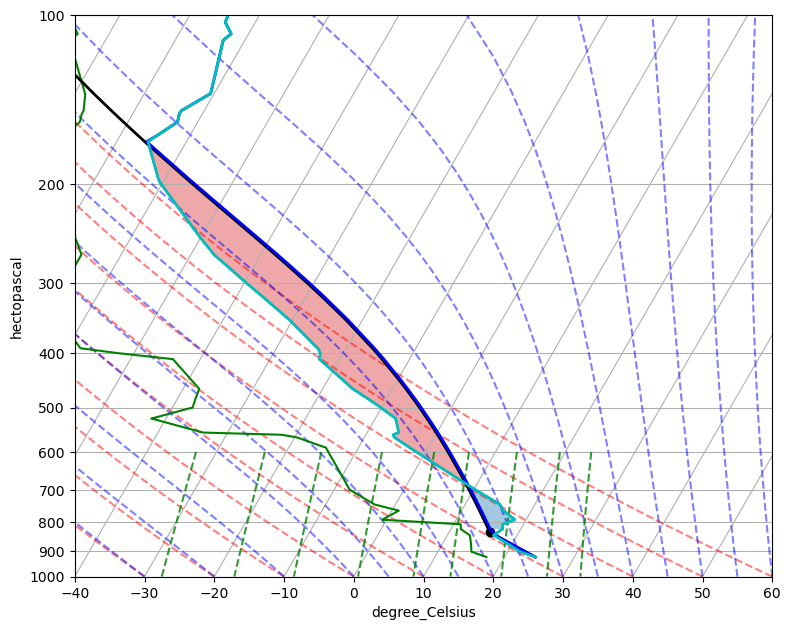

In [12]:
# add the SBM referece profile to the existing plot
sbm_Tref = np.flip(t_ref).squeeze() * units.kelvin
skew.plot(p, sbm_Tref, 'c', linewidth=2)
fig

The scheme produces no convective tendencies.

### Destabilize the surface with added moisture

We're going to create some deep convection by adding moisture to the profile. The SBM scheme will not produce deep convection unless both conditions are met:

$$P_q = -\int_{p_0}^{p_{LZB}} \delta q ~ dp/g > 0 $$
$$P_T = \int_{p_0}^{p_{LZB}} \frac{c_p}{L} \delta T ~ dp/g > 0 $$

(Frierson 2007, equations 3 and 4).

The positive CAPE in our profile means that we will meet the condition $P_T > 0$, but there is not enough moisture relative to the reference profile. So let's add more!

In [13]:
Twarm = T * np.ones_like(T) # unchanged temperature
Td_warm = Td + 5.*units('delta_degC')  # increased dewpoint

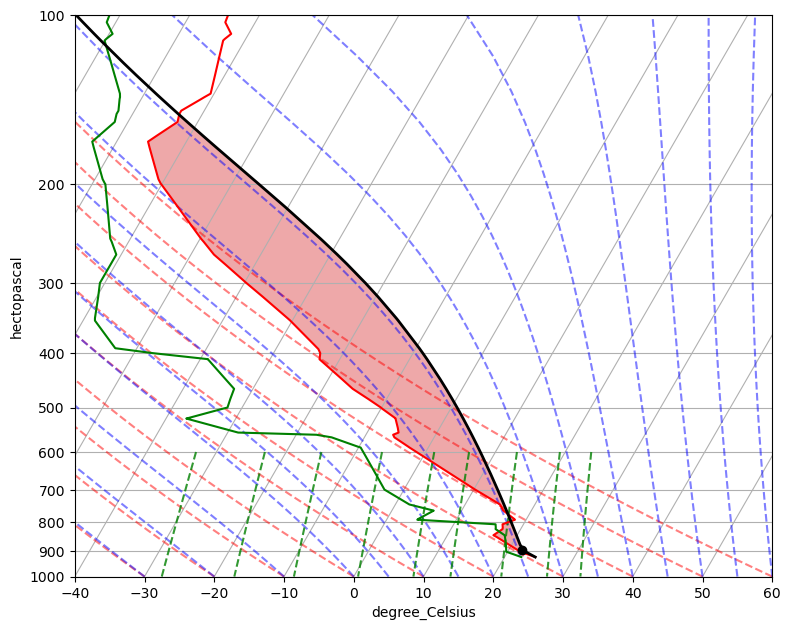

In [14]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, Twarm, 'r')
skew.plot(p, Td_warm, 'g')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)


# Calculate the LCL
lcl_pressure_warm, lcl_temperature_warm = mpcalc.lcl(p[0], Twarm[0], Td_warm[0])
# Calculate the parcel profile.
parcel_prof_warm = mpcalc.parcel_profile(p, Twarm[0], Td_warm[0]).to('degC')
# Plot LCL temperature as black dot
skew.plot(lcl_pressure_warm, lcl_temperature_warm, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof_warm, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, Twarm, parcel_prof_warm, Td_warm)
skew.shade_cape(p, Twarm, parcel_prof_warm)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

In [15]:
cape_metpy_warm, cin_metpy_warm = mpcalc.cape_cin(p, Twarm, Td, parcel_prof_warm)
print("CAPE from metpy is {}".format(cape_metpy_warm))
print("CIN from metpy is {}".format(cin_metpy_warm))

CAPE from metpy is 5801.307662136574 joule / kilogram
CIN from metpy is 0 joule / kilogram


In [16]:
tin_warm = np.flip(Twarm.to(units.kelvin).magnitude)
tin_grid_warm = tin_warm[np.newaxis, np.newaxis, :]

qin_warm = np.flip(mpcalc.specific_humidity_from_dewpoint(p, Td_warm).magnitude)
qin_grid_warm = qin_warm[np.newaxis, np.newaxis, :]

rain, tdel, qdel, q_ref, bmflag, klzbs, cape, cin, t_ref, invtau_bm_t, invtau_bm_q, capeflag = \
    _simplified_betts_miller.betts_miller(dt, tin_grid_warm, qin_grid_warm, pfull_grid, phalf_grid, 
                                          HLv, Cp_air, Grav,
                                          rdgas,rvgas,kappa, es0, tau_bm, rhbm, 
                                          do_simp, do_shallower, do_changeqref, 
                                          do_envsat, do_taucape, capetaubm, tau_min, 
                                          ix, jx, kx,)
cape, cin, rain, bmflag, capeflag

(array([[73.06134]], dtype=float32),
 array([[-5.2824445]], dtype=float32),
 array([[1.4249854]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32))

In [17]:
tdel

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e

In [18]:
Tnew = Twarm + np.flip(tdel.squeeze()) * units('delta_degC')
qnew = mpcalc.specific_humidity_from_dewpoint(p, Td_warm) + np.flip(qdel.squeeze())
Tdnew = mpcalc.dewpoint_from_specific_humidity(p, qnew)

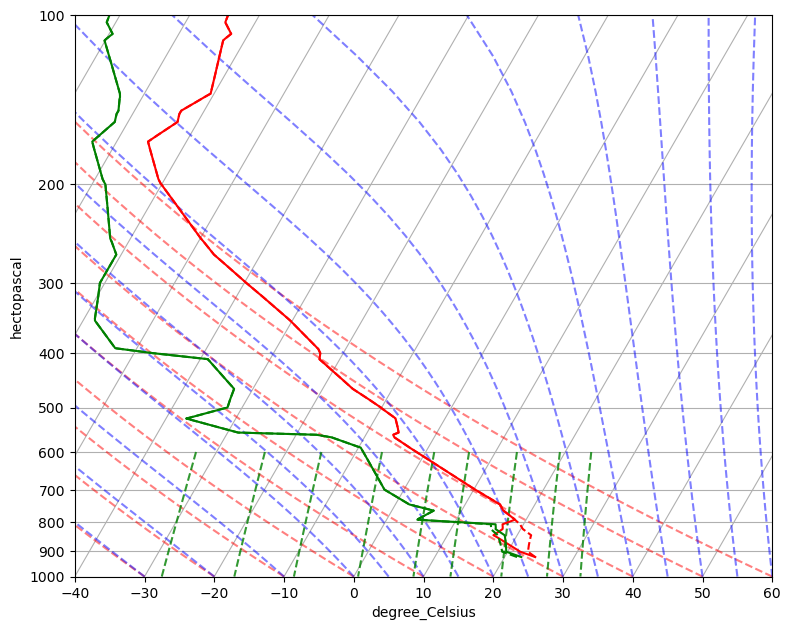

In [19]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, Twarm, 'r')
skew.plot(p, Td_warm, 'g')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

skew.plot(p, Tnew, 'r--')
skew.plot(p, Tdnew, 'g--')

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

This plot shows the change in temperature and dewpoint due to the convection. In this case the convective warming was confined to the lower levels.

## Using the climlab wrapper

We can hopefully compute the same tendencies using the Python wrapper developed for climlab

In [20]:
# We have wrapped the SBM code in a climlab process:
import climlab
from simplified_betts_miller import SimplifiedBettsMiller

### Do the stable case first

In [41]:
water_depth = 10.
short_timestep = const.seconds_per_hour * 3

full_state = climlab.column_state(water_depth = water_depth, lev=p)
full_state['Tatm'][:] = tin
full_state['q'] = 0.*full_state.Tatm + qin

conv = SimplifiedBettsMiller(name='Convection',
                             state=full_state,
                             do_simp=False,
                             do_shallower=True,
                             do_envsat=True,
                             do_taucape=False,
                             timestep=short_timestep,
                         )  
print(conv)

climlab Process of type <class 'simplified_betts_miller.SimplifiedBettsMiller'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (75,) 
  q: (75,) 
The subprocess tree: 
Convection: <class 'simplified_betts_miller.SimplifiedBettsMiller'>



In [42]:
conv.step_forward()

In [43]:
conv.diagnostics

{'precipitation': array([0.]),
 'cape': array([2605.31640625]),
 'cin': array([122.73005676])}

In [44]:
conv.tendencies

{'Ts': Field([0.]),
 'Tatm': Field([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+

### Now the unstable case

In [45]:
conv2 = climlab.process_like(conv)
conv2.Tatm[:] = tin_warm
conv2.q[:] = qin_warm

conv2.step_forward()
conv2.diagnostics

{'precipitation': array([0.00013194]),
 'cape': array([73.06134033]),
 'cin': array([-5.28244448])}

In [46]:
conv2.tendencies['Tatm'] * short_timestep

Field([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [48]:
conv2.tendencies['q'] * short_timestep

Field([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.0006098 , -0.00061414, -0.00

Note that the precipitation is reported in different units. The Fortran code reports total precip over the timestep in kg m$^{-2}$ (or mm), while climlab reports precipitation rate in kg m$^{-2}$ s$^{-1}$ or mm s$^{-1}$:

In [49]:
print(rain)  # in mm
print(rain / conv2.timestep) # in mm/s
print(conv2.diagnostics['precipitation'])

[[1.4249854]]
[[0.00013194]]
[0.00013194]


This confirms that the climlab wrapper `SimplifiedBettsMiller` produces the same tendencies as a manual call to the Fortran object.

## Coupling to climlab processes

In [50]:
from climlab.surface import SensibleHeatFlux, LatentHeatFlux
from climlab.radiation import RRTMG, DailyInsolation, AnnualMeanInsolation
from climlab import couple
from climlab.utils import constants as const

In [64]:
num_lev = 30
water_depth = 10.
short_timestep = const.seconds_per_hour * 3
long_timestep = short_timestep*3
insolation = 342.
albedo = 0.18

full_state = climlab.column_state(water_depth=water_depth, num_lev=num_lev)
# set initial conditions -- 24C at the surface, -60C at 200 hPa, isothermal stratosphere
strat_idx = 6
full_state['Tatm'][:strat_idx] = -60. + const.tempCtoK
full_state['Tatm'][strat_idx:] = np.linspace(-60, 22, num_lev-strat_idx) + const.tempCtoK
full_state['Ts'][:] = 24. + const.tempCtoK
# Use Manabe's profile as an initial condition for specific humidity
Q = full_state['Tatm'].domain.axes['lev'].points / const.ps
RHprofile = 0.7 * ((Q-0.02) / (1-0.02))
e = clausius_clapeyron(full_state['Tatm']) * RHprofile
qStrat = 5.E-6
qinitial = np.maximum(qStrat, e/full_state['Tatm'].domain.axes['lev'].points * const.Rd / const.Rv)
full_state['q'] = 0.*full_state.Tatm + qinitial

temperature_state = {'Tatm':full_state.Tatm,'Ts':full_state.Ts}
#  Surface model
shf = SensibleHeatFlux(name='Sensible Heat Flux',
                       state=temperature_state, Cd=3E-3,
                       timestep=short_timestep)
lhf = LatentHeatFlux(name='Latent Heat Flux',
                     state=full_state, Cd=3E-3,
                     timestep=short_timestep)
surface = couple([shf,lhf], name="Slab")
#  Convection scheme -- water vapor is a state variable
conv = SimplifiedBettsMiller(name='Convection',
                             state=full_state,
                             timestep=short_timestep,
                             do_simp=False,
                             do_shallower=True,
                             do_envsat=True,
                             do_taucape=False,
                         )  

rad = RRTMG(name='Radiation',
                state=temperature_state,
                specific_humidity=full_state.q,
                albedo=albedo,
                insolation=insolation,
                timestep=long_timestep,
                icld=0, # no clouds
                )
atm = couple([rad, conv], name='Atmosphere')
moistmodel = couple([atm,surface], name='Moist column model')

In [65]:
print(moistmodel)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
  q: (30,) 
The subprocess tree: 
Moist column model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Atmosphere: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
         SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
         LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
      Convection: <class 'simplified_betts_miller.SimplifiedBettsMiller'>
   Slab: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      Sensible Heat Flux: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
      Latent Heat Flux: <class 'climlab.surface.turbulent.LatentHeatFlux'>



In [66]:
moistmodel.step_forward()

In [67]:
moistmodel.q

Field([5.00000000e-06, 5.04327139e-06, 6.38814376e-06, 6.96451763e-06,
       7.28472534e-06, 7.48849388e-06, 7.62956441e-06, 1.20900224e-05,
       1.87787308e-05, 2.86472997e-05, 4.29866721e-05, 6.35248073e-05,
       9.25454919e-05, 1.33031201e-04, 1.88833016e-04, 2.64870642e-04,
       3.67365552e-04, 5.04110226e-04, 6.84776333e-04, 9.21264526e-04,
       1.22809830e-03, 1.62286408e-03, 2.12669940e-03, 2.76483064e-03,
       3.56716145e-03, 4.56891251e-03, 5.81131279e-03, 7.34234220e-03,
       9.21752476e-03, 1.55846442e-02])

In [68]:
moistmodel.integrate_days(30)

Integrating for 240 steps, 30.000000000000004 days, or 0.08213727767492365 years.
Total elapsed time is 0.0824795163319025 years.


In [69]:
moistmodel.q

Field([5.00000000e-06, 5.04327139e-06, 6.38814376e-06, 6.96451763e-06,
       7.28472534e-06, 7.48849388e-06, 6.25653431e-05, 1.50832525e-04,
       3.07915843e-04, 5.48001161e-04, 8.83314785e-04, 1.26901624e-03,
       1.72862813e-03, 2.23280473e-03, 2.77142410e-03, 3.33947514e-03,
       3.93382616e-03, 4.67210613e-03, 5.14844037e-03, 5.73853314e-03,
       6.09007608e-03, 6.71047152e-03, 7.29320954e-03, 7.82826399e-03,
       8.34813571e-03, 8.85576891e-03, 9.35145772e-03, 9.83609331e-03,
       1.03198223e-02, 1.31529063e-02])

In [70]:
moistmodel.integrate_years(1)

Integrating for 2921 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.0821586333671191 years.


In [71]:
moistmodel.Ts

Field([295.23629516])

In [72]:
moistmodel.cape

array([164.46621704])

In [73]:
moistmodel.q

Field([5.00000000e-06, 5.04327139e-06, 6.38814376e-06, 6.96451763e-06,
       7.28472534e-06, 7.48849388e-06, 1.06310709e-04, 2.48091475e-04,
       4.85530806e-04, 8.24653520e-04, 1.25739611e-03, 1.76481510e-03,
       2.32339859e-03, 2.92202678e-03, 3.55381202e-03, 4.20886062e-03,
       4.87623132e-03, 5.54516395e-03, 6.20357458e-03, 7.07689737e-03,
       7.72783792e-03, 8.35259097e-03, 8.96070114e-03, 9.55197307e-03,
       1.01270267e-02, 1.06852759e-02, 1.12284154e-02, 1.17564068e-02,
       1.22685446e-02, 1.19189045e-02])

This runs without blowing up now, but why isn't the atmosphere getting moister above the first level?

In [74]:
conv.diagnostics

{'precipitation': array([0.]),
 'cape': array([164.46621704]),
 'cin': array([0.])}

In [75]:
moistmodel.timeave

{'Tatm': Field([238.81580192, 221.02780625, 214.8277738 , 213.57637125,
        213.94652322, 215.64494926, 218.97566768, 227.71866059,
        235.38905842, 242.06473607, 247.86139845, 252.90378828,
        257.30955412, 261.19750607, 264.67035432, 267.8014731 ,
        270.64458784, 273.24114984, 275.624105  , 277.81724118,
        279.8530051 , 281.74659534, 283.51741019, 285.18599278,
        286.7604615 , 288.25234862, 289.67001802, 291.02150726,
        292.31559757, 294.01628905]),
 'Ts': Field([294.43178329]),
 'q': Field([5.00000000e-06, 5.04327139e-06, 6.38814376e-06, 6.96451763e-06,
        7.28472534e-06, 7.48849388e-06, 8.63437535e-05, 2.03255231e-04,
        4.04032293e-04, 6.98699780e-04, 1.08405044e-03, 1.54562814e-03,
        2.06308171e-03, 2.62250415e-03, 3.21663521e-03, 3.83681225e-03,
        4.47274772e-03, 5.11434415e-03, 5.75146234e-03, 6.38490896e-03,
        7.01459693e-03, 7.62569723e-03, 8.21315304e-03, 8.79704878e-03,
        9.34817601e-03, 9.88235885e-03,

Looks like I've finally succeeded in getting some convective moistening above the surface.

In [77]:
moistmodel.q - qinitial

Field([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.86811443e-05, 2.36001453e-04,
       4.66752075e-04, 7.96006220e-04, 1.21440943e-03, 1.70129029e-03,
       2.23085310e-03, 2.78899558e-03, 3.36497901e-03, 3.94398998e-03,
       4.50886577e-03, 5.04105372e-03, 5.51879824e-03, 6.15563284e-03,
       6.49973962e-03, 6.72972689e-03, 6.83400174e-03, 6.78714244e-03,
       6.55986521e-03, 6.11636338e-03, 5.41710264e-03, 4.41406462e-03,
       3.05101987e-03, 4.18133268e-04])

In [78]:
moistmodel.integrate_years(1)

Integrating for 2921 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.0818377504023355 years.


In [79]:
moistmodel.timeave['precipitation']

array([4.23958861e-05])

In [80]:
moistmodel.precipitation

array([0.])

This model must experience some sporadic precipitation events.

In [87]:
steps0 = moistmodel.time['steps']
moistmodel.step_forward()
while moistmodel.precipitation[0] == 0.:
    moistmodel.step_forward()
moistmodel.time['steps'] - steps0

6

There is rain every sixth timestep in this configuration.

Time averaged precip and evaporation rates in mm / year

In [93]:
print(moistmodel.timeave['precipitation'] * const.seconds_per_year)
print(moistmodel.timeave['evaporation'] * const.seconds_per_year)

[1337.88384415]
[1341.26667084]


To do: make a cute animation showing the adjustment from initial condition to a stable equilibrium in a single column.